<h1 style="color:#3295ec;"><center>In the Name of God</center></h1>

<h3 style="color:#3295ec;"><center>Project 3 - Artificial Neural Networks - Part a</center></h3>
<p style="text-align: right;">Student: Mozhdeh Ahrabi Tabriz</p>

<p style="text-align: right;">Student No.: 96722216</p>

In [ ]:
####################
# Import Libraries #
####################

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

/home/hgirlwxx/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
################
# Loading Data #
################
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('data/MNIST', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


<h2 style="color:#3295ec;text-align: right;">Section 1: Defining functions to create the network</h2>

In [ ]:
def flatten_layer(layer):
    #___ defining in order to reshape the last convolution layer into a flat vector
    #___ and calculating the number of features in it
    with tf.name_scope("Layer_Flattening"):
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
        return layer_flat, num_features

def add_conv_layer(pre_layer, layer_shape, num_of_filters, pooling, batch_norm):
    #___ defining in order to create a new convolution layer with a given shape
    with tf.name_scope("Convolutional_Layer") as scope:
        #___ calculating layer weights (filters) and its biases
        #___ then creating convolution layer
        new_weights = tf.Variable(tf.truncated_normal(layer_shape, stddev=0.1), name="weights")
        new_biases = tf.Variable(tf.constant(0.1, shape=[num_of_filters], name="bias"))
        conv2d = tf.nn.conv2d(input=pre_layer, 
                                 filter=new_weights,
                                 strides=[1, 1, 1, 1],
                                 padding="SAME",
                                 name="conv2d")
        conv2d += new_biases
    if batch_norm:
        with tf.name_scope("Batch_Normalization"):
            #___ if batch_norm flag is true, then normalizing the convolution layer
            conv2d = tf.layers.batch_normalization(conv2d, training=True)
    with tf.name_scope("Nonlinear_Layer"):
        #___ Using Rectified Linear Unit as activation function for the convolution layer
        conv2d = tf.nn.relu(conv2d, name="ReLU")
    if pooling:
        with tf.name_scope("Pooling_Layer"):
            #___ max plooing in order to downsampling the features extracted
            conv2d = tf.nn.max_pool(value=conv2d,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name="max_pool")
    return conv2d, new_weights

def new_fc_layer(pre_layer, num_of_pre_neurons, num_of_post_neurons, relu_activation=True):
    #___ defining in order to create a new fully connected layer 
    #___ used for fully connected layer of convolution layer and read-out layer
    with tf.name_scope("Fully_Connected_Layer"):
        #___ same as previous, defining weights and biases and using ReLU 
        #___ to create a new fully connected layer
        new_weights = tf.Variable(tf.truncated_normal(shape=[num_of_pre_neurons, num_of_post_neurons], stddev=0.1), name="weights")
        new_biases = tf.Variable(tf.constant(0.1, shape=[num_of_post_neurons], name="bias"))
        fully_connected_layer = tf.matmul(pre_layer, new_weights, name="matmul") + new_biases
        if relu_activation:
            fully_connected_layer = tf.nn.relu(fully_connected_layer, name="ReLU")
        return fully_connected_layer

def prediction(training_data, net_architecture, num_of_fc_layer_neurons, num_of_classes, keep_prob):
    #___ defining in order to find the network prediction for training data based on the given architecture
    layers = [training_data]
    weights = list()
    for layer_specification in net_architecture:
        #___ each element of net_architecture is a hidden layer structure
        new_conv, new_weights = add_conv_layer(pre_layer=layers[-1],
                                                    layer_shape=layer_specification["shape"],
                                                    num_of_filters=layer_specification["shape"][-1],
                                                    pooling=layer_specification["pooling"],
                                                    batch_norm=layer_specification["batch_norm"])
        layers.append(new_conv)
        weights.append(new_weights)
    flat_layer, num_of_features = flatten_layer(layers[-1])
    fc_of_last_conv = new_fc_layer(flat_layer, num_of_features, num_of_fc_layer_neurons)
    h_fc1_drop = tf.nn.dropout(fc_of_last_conv, keep_prob)
    prediction_fc_layer = new_fc_layer(h_fc1_drop, num_of_fc_layer_neurons, num_of_classes, False)
    y_prediction = tf.nn.softmax(prediction_fc_layer, name="softmax")
    return prediction_fc_layer, y_prediction

def optimization(logits, y_prediction, target_value, learning_rate):
    #___ defining in order to optimize the network loss
    with tf.name_scope("Optimization"):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=target_value)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name="optimization")
        loss = tf.reduce_mean(cross_entropy, name="loss")
        return loss, optimizer.minimize(loss)

def calc_accuracy(target_value, y_prediction):
    #___ defining in order to calculate model accuracy 
    y_true_class = tf.argmax(target_value, axis=1)
    y_pre_class = tf.argmax(y_prediction, axis=1)
    correct_prediction = tf.equal(y_true_class, y_pre_class)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")

def print_confusion_matrix(target_class, predicted_class, num_of_classes):
    #___ defining in order to calculating confusion matrix using sklearn.metrics.confusion_matrix
    #___ and plotting it
    cm = confusion_matrix(y_true=target_class, y_pred=predicted_class)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(num_of_classes)
    plt.xticks(tick_marks, range(num_of_classes))
    plt.yticks(tick_marks, range(num_of_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

<h2 style="color:#3295ec;text-align: right;">Section 2: Defining train and evaluation procedures</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
The facing problem is the recognition of handwritten numbers ranging from 0 to 9 provided as images. One of the appropriate solutions is to take advantage of architectures based on convoluational layers in which training procedure has been inspired by human's vision.
</p>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
Therefore, firstly we should define the input space, then regarding to the desired structre for hidden layers (adjustable through network architecture variable) and using the methods have been defined in section 1, the network should be created.
</p>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
To do so, it would be enough to feed the input to defined layers, and, after calculating the networks output, the error between output and expected ones should be assessed. Then, using an optimization method the loss or mutual entropy should be decreased. Finally, the accuracy of data on the trained network is calculated. The process repeats for the number of epochs have been declared. While saving the change of some parameters including loss and accuracy, the model, itself, is being saved too.
After the training process has finished model accuracy is evaluated based on training and test data, and confusion matrix and its corresponding diagram is plotted.
</p>

In [ ]:
def evaluate(data, batch_step, epochs, image_width, image_channels, net_arch, learning_rate, fc_neurons, num_of_classes, test_batch_size, model_name):
    tf.reset_default_graph()
    #########
    # Train #
    #########
    #___ defining input, output and keep probability of dropout operation
    x = tf.placeholder(tf.float32, shape=[None, image_width*image_width], name='x')
    x_image = tf.reshape(x, [-1, image_width, image_width, image_channels])
    tf.summary.image('input', x_image, 10)
    y_true = tf.placeholder(tf.float32, shape=[None, num_of_classes], name='y_true')
    y_true_cls = tf.argmax(y_true, axis=1)
    keep_prob = tf.placeholder(tf.float32)
    #***********************************************************************************
    #___ declaring network scops and the necessary scalars to collect
    logits, y_prediction = prediction(x_image, net_arch, fc_neurons, num_of_classes, keep_prob)
    y_pred_cls = tf.argmax(y_prediction, axis=1)
    loss, optimizer = optimization(logits, y_prediction, y_true, learning_rate)
    loss_histogram = tf.summary.scalar("loss", loss)
    accuracy = calc_accuracy(y_true, y_prediction)
    accuracy_histogram = tf.summary.scalar("accuracy", accuracy)
    merged = tf.summary.merge_all()
    #***********************************************************************************
    #___ defining saver, session and summary writers
    with tf.Session() as session:
        saver = tf.train.Saver()
        session.run(tf.global_variables_initializer())
        train_writer = tf.summary.FileWriter('./CNN/'+model_name+'/logs/train/'+model_name)
        test_writer = tf.summary.FileWriter('./CNN/'+model_name+'/logs/test/'+model_name)
        train_writer.add_graph(session.graph)
        start_time = time.time()
        #***********************************************************************************
        print("Training has been started... ")
        for epoch in range(1, epochs+1):
            #___ extracting train data batch
            batch_x, batch_y = data.train.next_batch(batch_step)
            batch_re_x = np.reshape(batch_x, [-1, image_width, image_width, image_channels])
            feed_train = {x: batch_x, y_true: batch_y, keep_prob: 1.0}
            #---------------------------------------------------------------------------------------
            #___ extracting test data batch
            test_batch_x, test_batch_y = data.test.next_batch(batch_step)
            test_reshape_x = np.reshape(test_batch_x, [-1, image_width, image_width, image_channels])
            feed_test = {x: test_batch_x, y_true: test_batch_y, keep_prob: 0.9}
            #---------------------------------------------------------------------------------------
            #___ run the network optmizer declared above with train data extracted before
            session.run(optimizer, feed_dict=feed_train)
            #___ every 10 epoch, calculating train and test accuracy and collect their summaries
            if epoch % 10 == 0:
                train_summary, train_accuracy = session.run([merged, accuracy], feed_dict=feed_train)
                train_writer.add_summary(train_summary, epoch)
                test_summary, test_accuracy = session.run([merged, accuracy], feed_dict=feed_test)
                test_writer.add_summary(test_summary, epoch)
                print("Optimization epoch: {0:>6}, Training Accuracy: {1:>6.1%},  Test Accuracy: {2:>6.1%}".format(epoch, train_accuracy, test_accuracy))
            #___ every 100 epoch, writing the summaries as methadata in logs
            if epoch % 100 == 0 or epoch == epochs:
                print('\nAdding run metadata for epoch ' + str(epoch) + '\n')
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
                summary, _ = session.run([merged, optimizer],
                                      feed_dict={x: batch_x, y_true: batch_y, keep_prob: 1.0},
                                      options=run_options,
                                      run_metadata=run_metadata)
                train_writer.add_run_metadata(run_metadata, 'step%03d' % epoch)
                train_writer.add_summary(summary, epoch)
        stop_time = time.time()
        print("Training duration: " + str(timedelta(seconds=int(round(stop_time - start_time)))))
        print('\nSaving model at ' + str(epoch) + ' epochs.')
        saver.save(session, './CNN/'+model_name+'/models/'+model_name, global_step=epoch)
        train_writer.close()
        test_writer.close()
        print("Training has been finished... ")
        ####################
        # Final Evaluation #
        ####################
        #___ calculating accuracy on train-set, test-set and validation-set
        #___ and plotting corresponding confusion matrices
        print("\n Final evaluation has been started... ")
        num_test = len(data.train.images)
        cls_pred = np.zeros(shape=num_test, dtype=np.int)
        i = 0
        while i < num_test:
            j = min(i + test_batch_size, num_test)
            images = data.train.images[i:j, :]
            labels = data.train.labels[i:j, :]
            feed_dict = {x: images,
                         y_true: labels, keep_prob: 1.0}
            cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
            i = j
        cls_true = np.argmax(data.train.labels, axis=1)
        correct = (cls_true == cls_pred)
        correct_sum = correct.sum()
        acc = float(correct_sum) / num_test
        msg = "Accuracy on Train-Set: {0:.1%} ({1} / {2})"
        print(msg.format(acc, correct_sum, num_test))
        print_confusion_matrix(cls_true, cls_pred, num_of_classes)
        #---------------------------------------------------------------------------------------    
        num_test = len(data.test.images)
        cls_pred = np.zeros(shape=num_test, dtype=np.int)
        i = 0
        while i < num_test:
            j = min(i + test_batch_size, num_test)
            images = data.test.images[i:j, :]
            labels = data.test.labels[i:j, :]
            feed_dict = {x: images,
                         y_true: labels, keep_prob: 1.0}
            cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
            i = j
        cls_true = np.argmax(data.test.labels, axis=1)
        correct = (cls_true == cls_pred)
        correct_sum = correct.sum()
        acc = float(correct_sum) / num_test
        msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
        print(msg.format(acc, correct_sum, num_test))
        print_confusion_matrix(cls_true, cls_pred, num_of_classes)
        #---------------------------------------------------------------------------------------
        num_test = len(data.validation.images)
        cls_pred = np.zeros(shape=num_test, dtype=np.int)
        i = 0
        while i < num_test:
            j = min(i + test_batch_size, num_test)
            images = data.validation.images[i:j, :]
            labels = data.validation.labels[i:j, :]
            feed_dict = {x: images,
                         y_true: labels, keep_prob: 1.0}
            cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
            i = j
        cls_true = np.argmax(data.validation.labels, axis=1)
        correct = (cls_true == cls_pred)
        correct_sum = correct.sum()
        acc = float(correct_sum) / num_test
        msg = "Accuracy on Validation-Set: {0:.1%} ({1} / {2})"
        print(msg.format(acc, correct_sum, num_test))
        print_confusion_matrix(cls_true, cls_pred, num_of_classes)

<h2 style="color:#3295ec;text-align: right;">Section 3: Model defining and evaluating</h2>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
Firstly an architecture is declared for the hidden layers. Also, defining whether each layer would enjoy batch normalization, down-sampling using pooling or not. Then, by calling evaluation method and initializing hyperparameters such as epochs, batch number, and learning rate, the model is trained and evaluated and the results are analyzed.
</p>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
Recommended structre: Convolutional neural network with two hidden layers having a convolution layer with number of filters 32 and 64 respectively. Covolution window size is $5 \times 5$. A nonlinear layer consisting of Rectifier function (ReLU) and a down-sampling pooling layer are recommended.
</p>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
Recommended structure justification: having run quite a few tests on various hyperparameters, this model was the most appropriate one leading to the highest accuracy.
</p>
<p style="text-align: right;font-size:15px; margin-right: 10%;direction:rtl;">
Hyperparameters:
<ul>
Epochs: 200
</ul>
<ul>
Batch size: 500
</ul>
<ul>
Learning rate: 0.0008
</ul>
<ul>
Fully-connecte layer size: 1024 (# neurons)
</ul>
</p>

In [ ]:
####################
# Net Architecture #
####################
net_arc = [{"shape": [5,5,1,32], "batch_norm": False, "pooling":True},
           {"shape": [5,5,32,64], "batch_norm": False, "pooling":True}]

Training has been started... 
Optimization epoch:     10, Training Accuracy:  46.2%,  Test Accuracy:  39.2%
Optimization epoch:     20, Training Accuracy:  65.4%,  Test Accuracy:  63.4%
Optimization epoch:     30, Training Accuracy:  83.0%,  Test Accuracy:  82.4%
Optimization epoch:     40, Training Accuracy:  89.6%,  Test Accuracy:  89.6%
Optimization epoch:     50, Training Accuracy:  92.4%,  Test Accuracy:  92.0%
Optimization epoch:     60, Training Accuracy:  94.4%,  Test Accuracy:  94.4%
Optimization epoch:     70, Training Accuracy:  94.4%,  Test Accuracy:  94.6%
Optimization epoch:     80, Training Accuracy:  97.6%,  Test Accuracy:  95.6%
Optimization epoch:     90, Training Accuracy:  96.0%,  Test Accuracy:  96.0%
Optimization epoch:    100, Training Accuracy:  96.0%,  Test Accuracy:  95.2%

Adding run metadata for epoch 100

Optimization epoch:    110, Training Accuracy:  96.6%,  Test Accuracy:  96.0%
Optimization epoch:    120, Training Accuracy:  97.4%,  Test Accuracy:  97.0

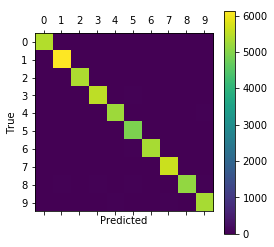

Accuracy on Test-Set: 97.9% (9792 / 10000)
[[ 975    1    0    0    0    1    1    1    1    0]
 [   0 1131    3    0    1    0    0    0    0    0]
 [   8    6 1003    5    3    0    0    6    0    1]
 [   0    0    2  994    0    6    0    6    2    0]
 [   0    0    0    0  971    0    1    1    1    8]
 [   3    0    0    6    0  881    1    1    0    0]
 [   9    3    1    1    1    4  938    0    1    0]
 [   1    4   10    1    2    0    0 1006    1    3]
 [   9    1    8   10    2    4    2    4  927    7]
 [   7    7    2    6    9    3    0    8    1  966]]


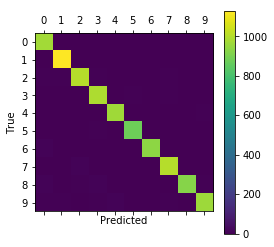

Accuracy on Validation-Set: 98.1% (4906 / 5000)
[[476   1   0   0   0   0   1   1   0   0]
 [  0 557   2   1   1   0   0   2   0   0]
 [  0   5 476   1   1   1   0   2   1   1]
 [  0   1   3 484   0   2   0   2   0   1]
 [  0   1   0   0 529   0   0   2   0   3]
 [  0   1   1   3   0 428   0   0   1   0]
 [  2   2   1   0   1   3 490   0   2   0]
 [  2   2   1   0   0   1   0 542   0   2]
 [  0   2   5   1   3   5   1   0 444   1]
 [  4   2   0   2   0   1   0   6   0 480]]


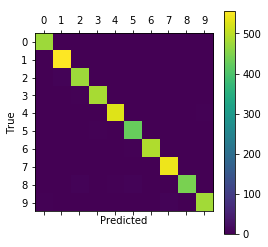

In [ ]:
evaluate(data=mnist_data, batch_step=500, epochs=200, image_width=28, image_channels=1,
      net_arch=net_arc, learning_rate=8e-4, fc_neurons=1024, num_of_classes=10, test_batch_size=250, model_name="32_64_500_8e4_1024")

In [ ]:
####################
# Net Architecture #
####################
net_arc_2_bn = [{"shape": [5,5,1,32], "batch_norm": True, "pooling":True},
           {"shape": [5,5,32,64], "batch_norm": True, "pooling":True}]

Training has been started... 
Optimization epoch:     10, Training Accuracy:  66.2%,  Test Accuracy:  64.0%
Optimization epoch:     20, Training Accuracy:  83.2%,  Test Accuracy:  81.8%
Optimization epoch:     30, Training Accuracy:  88.8%,  Test Accuracy:  86.6%
Optimization epoch:     40, Training Accuracy:  91.0%,  Test Accuracy:  90.8%
Optimization epoch:     50, Training Accuracy:  92.2%,  Test Accuracy:  91.2%
Optimization epoch:     60, Training Accuracy:  94.6%,  Test Accuracy:  90.2%
Optimization epoch:     70, Training Accuracy:  94.2%,  Test Accuracy:  91.4%
Optimization epoch:     80, Training Accuracy:  96.8%,  Test Accuracy:  93.0%
Optimization epoch:     90, Training Accuracy:  94.4%,  Test Accuracy:  93.2%
Optimization epoch:    100, Training Accuracy:  94.8%,  Test Accuracy:  92.6%

Adding run metadata for epoch 100

Optimization epoch:    110, Training Accuracy:  94.6%,  Test Accuracy:  91.8%
Optimization epoch:    120, Training Accuracy:  96.8%,  Test Accuracy:  93.6

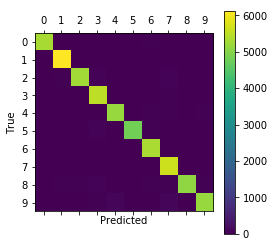

Accuracy on Test-Set: 97.3% (9729 / 10000)
[[ 970    0    1    0    0    2    3    1    3    0]
 [   0 1129    1    1    1    0    1    1    1    0]
 [   6    6  997    9    0    0    3    8    3    0]
 [   0    2    2  995    0    1    0    8    2    0]
 [   0    3    3    1  958    0    4    3    2    8]
 [   3    0    1   18    1  854    7    1    6    1]
 [   3    3    0    0    3    3  944    0    2    0]
 [   0    1    5    6    3    0    0 1013    0    0]
 [   5    0    9   19    5    2    4    8  916    6]
 [   4    8    1    7   16    4    0   15    1  953]]


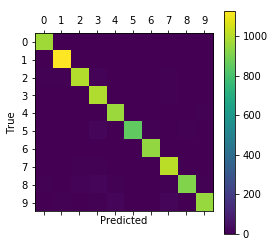

Accuracy on Validation-Set: 97.2% (4858 / 5000)
[[469   1   1   1   0   0   3   2   1   1]
 [  0 557   2   2   1   0   0   1   0   0]
 [  1   5 468   3   2   1   1   3   2   2]
 [  0   2   2 480   0   0   1   4   1   3]
 [  0   0   0   0 525   0   3   2   0   5]
 [  0   1   2   6   0 416   4   1   4   0]
 [  1   1   0   0   1   1 497   0   0   0]
 [  1   2   2   3   2   0   0 538   0   2]
 [  1   1   7   6   2   2   2   2 438   1]
 [  2   1   2   5   4   1   0  10   0 470]]


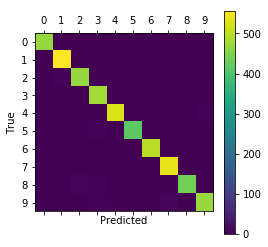

In [ ]:
evaluate(data=mnist_data, batch_step=500, epochs=200, image_width=28, image_channels=1,
      net_arch=net_arc_2_bn, learning_rate=8e-4, fc_neurons=1024, num_of_classes=10, test_batch_size=250, model_name="new_32_64_500_8e4_1024_BN")

In [ ]:
####################
# Net Architecture #
####################
net_arc_2_deep = [{"shape": [5,5,1,64], "batch_norm": False, "pooling":True},
                  {"shape": [5,5,64,128], "batch_norm": False, "pooling":True}]

Training has been started... 
Optimization epoch:     10, Training Accuracy:  35.0%,  Test Accuracy:  33.2%
Optimization epoch:     20, Training Accuracy:  60.4%,  Test Accuracy:  53.4%
Optimization epoch:     30, Training Accuracy:  84.0%,  Test Accuracy:  80.4%
Optimization epoch:     40, Training Accuracy:  90.4%,  Test Accuracy:  88.6%
Optimization epoch:     50, Training Accuracy:  92.6%,  Test Accuracy:  94.2%
Optimization epoch:     60, Training Accuracy:  95.0%,  Test Accuracy:  93.2%
Optimization epoch:     70, Training Accuracy:  94.8%,  Test Accuracy:  93.4%
Optimization epoch:     80, Training Accuracy:  96.8%,  Test Accuracy:  94.6%
Optimization epoch:     90, Training Accuracy:  95.8%,  Test Accuracy:  95.4%
Optimization epoch:    100, Training Accuracy:  94.8%,  Test Accuracy:  95.6%

Adding run metadata for epoch 100

Optimization epoch:    110, Training Accuracy:  97.0%,  Test Accuracy:  97.0%
Optimization epoch:    120, Training Accuracy:  97.2%,  Test Accuracy:  96.2

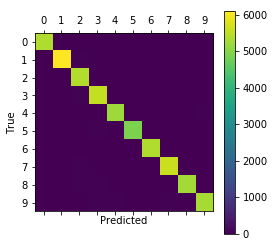

Accuracy on Test-Set: 98.0% (9805 / 10000)
[[ 970    0    4    0    0    1    2    1    2    0]
 [   0 1124    2    1    0    1    5    0    2    0]
 [   3    2 1017    4    0    0    0    1    5    0]
 [   1    0    4  995    0    2    0    3    4    1]
 [   0    0    3    0  970    0    3    0    1    5]
 [   2    0    0    8    0  877    2    1    1    1]
 [   6    2    1    0    2    3  942    0    2    0]
 [   0    3   15    7    2    0    0  997    2    2]
 [   7    0    5    8    2    3    1    2  945    1]
 [   6    5    1   10    8    3    0    5    3  968]]


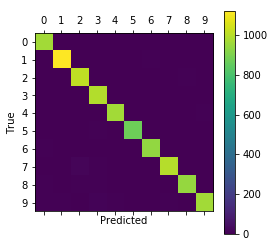

Accuracy on Validation-Set: 98.4% (4919 / 5000)
[[478   1   0   0   0   0   0   0   0   0]
 [  0 553   2   2   2   0   1   2   1   0]
 [  0   2 481   2   0   0   0   2   1   0]
 [  0   0   2 488   0   1   0   1   0   1]
 [  0   0   1   0 529   0   1   1   0   3]
 [  0   1   1   3   0 425   3   0   1   0]
 [  1   0   0   0   0   3 496   0   1   0]
 [  1   2   2   1   2   1   0 536   1   4]
 [  0   0   3   0   0   3   1   1 453   1]
 [  2   1   0   3   1   1   1   5   1 480]]


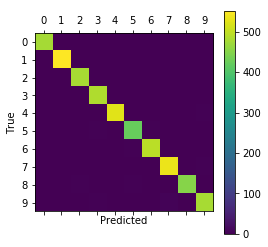

In [ ]:
evaluate(data=mnist_data, batch_step=500, epochs=200, image_width=28, image_channels=1,
      net_arch=net_arc_2_deep, learning_rate=8e-4, fc_neurons=1024, num_of_classes=10, test_batch_size=250, model_name="64_128_500_8e4")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
base_path = '/content/drive/MyDrive/Master_Projects/'
import os
os.listdir(base_path)

['ANN_HW3_LSTM_a_Ahrabi_96722216.ipynb',
 'ANN_HW3_LSTM_b_Ahrabi_96722216.ipynb',
 'CNN',
 'data',
 'lstm_',
 'LSTM',
 'png_out',
 'ANN_HW3_CNN_Ahrabi_96722216.ipynb']

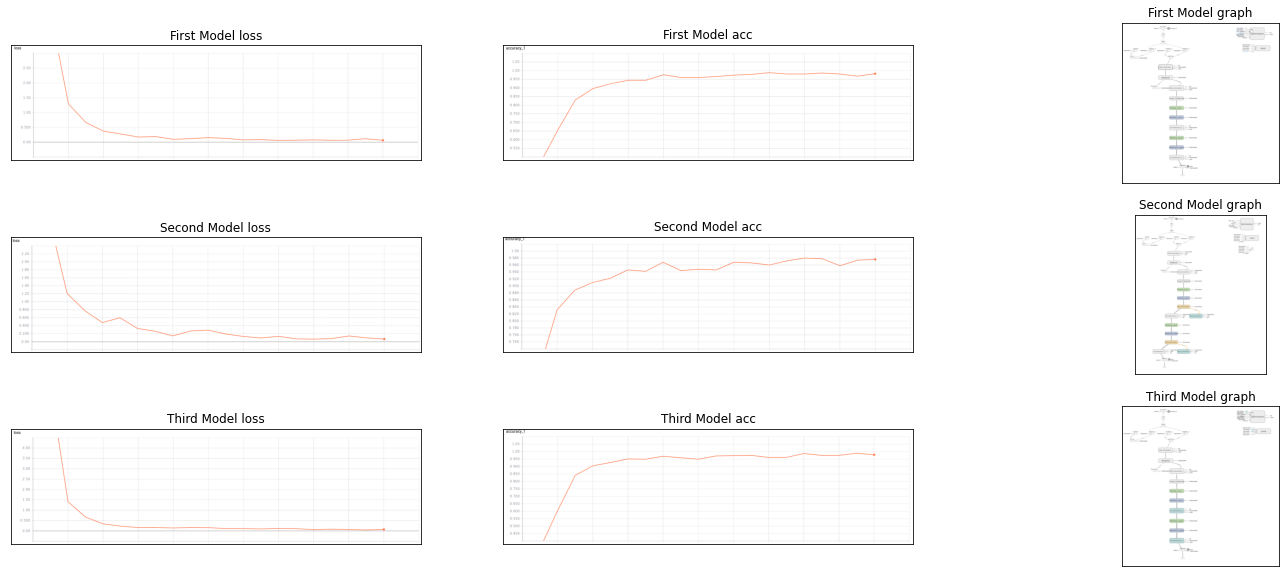

In [11]:
from skimage import io
import matplotlib.pylab as plt

num = ['first', 'second', 'third']
fig, axarr = plt.subplots(3, 3, figsize=(25,10))

for i in range(len(num)):
  stat = ['loss', 'acc', 'graph']
  for j in range(len(num)):
    image = io.imread(f'{base_path}png_out/{num[i]}_{stat[j]}.png')
    axarr[i][j].imshow(image)
    axarr[i][j].set_title(f'{num[i].capitalize()} Model {stat[j]}'), 
    axarr[i][j].axes.xaxis.set_ticks([]), axarr[i][j].axes.xaxis.set_ticklabels([])
    axarr[i][j].axes.yaxis.set_ticks([]), axarr[i][j].axes.yaxis.set_ticklabels([])

plt.show()

<h2 style="color:#3295ec;text-align: right;">Section 4: Analysis</h2>
<li>
Learning rate change: Increasing learning rate end up with not converging through 200 epochs and the generalization is quite low.
</li>
<li>
Loss rate change: The plummeting rate is rapid for First Model, Thrid Model, and Second Model orderly, and their loss rate fluctuations are highest in the Second Model while the changes in First Model with no batch normalizations is smoother.
</li>
<li>
Depth increase (# filters): The more filters are, the more features are extracted, so by finding suitable other parameters the total accuracy could increase. Here, hyperparameters are remained constant. With further study on training and test data, accuracy has not changed significantly. Thus, it is better to use simpler with less filters instead.
</li>
<li>
Batch normalization: Using it led to a decrease in generalization; however, generally this layer is used before rectifier function although some resources assert that using it after rectifier function would lead to less loss rate. However, by investigating this assertion too, the accuracy becomes less in comparison to not using it.
</li>